# Drifting Upstream: Preprocessing and Training Data

## Load Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline

## Load Data

In [2]:
df = pd.read_csv('spotify_2023_streams_and_features.csv', index_col=0)
df.head()

,streams,bpm,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,mode
0,141381703,125,80,89,83,31,0,8,4,1
1,133716286,92,71,61,74,7,0,10,4,1
2,140003974,138,51,32,53,17,0,31,6,1
3,800840817,170,55,58,72,11,0,11,15,1
4,303236322,144,65,23,80,14,63,11,6,0


In [5]:
df.shape

(945, 10)

In [6]:
df.isna().sum()

streams             0
bpm                 0
danceability        0
valence             0
energy              0
acousticness        0
instrumentalness    0
liveness            0
speechiness         0
mode                0
dtype: int64

## Initial Train/Test Split

We will partition the dataset into a 70/30 split of a training set and a test set. By fitting and training our model on the training set, it can evaluate the test sit without the bias of having already seen these same data. Since our target variable, streams, has such high values, we will convert this into it's log value for our predictive modeling. We can then convert back to assess actual predicted stream counts.

In [7]:
feature_names = list(df.drop(columns='streams').columns)
feature_names

['bpm',
 'danceability',
 'valence',
 'energy',
 'acousticness',
 'instrumentalness',
 'liveness',
 'speechiness',
 'mode']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='streams'), np.log(df['streams']), test_size=0.3, random_state=42)

In [9]:
X_train.shape, X_test.shape

((661, 9), (284, 9))

In [10]:
y_train.shape, y_test.shape

((661,), (284,))

Let's confirm that all of our features are numeric.

In [11]:
X_train.dtypes

bpm                 int64
danceability        int64
valence             int64
energy              int64
acousticness        int64
instrumentalness    int64
liveness            int64
speechiness         int64
mode                int64
dtype: object

In [12]:
X_test.dtypes

bpm                 int64
danceability        int64
valence             int64
energy              int64
acousticness        int64
instrumentalness    int64
liveness            int64
speechiness         int64
mode                int64
dtype: object

## Establishing Performance Metrics

As a reminder, let's evaluate how each of our features and target variable are distributed.

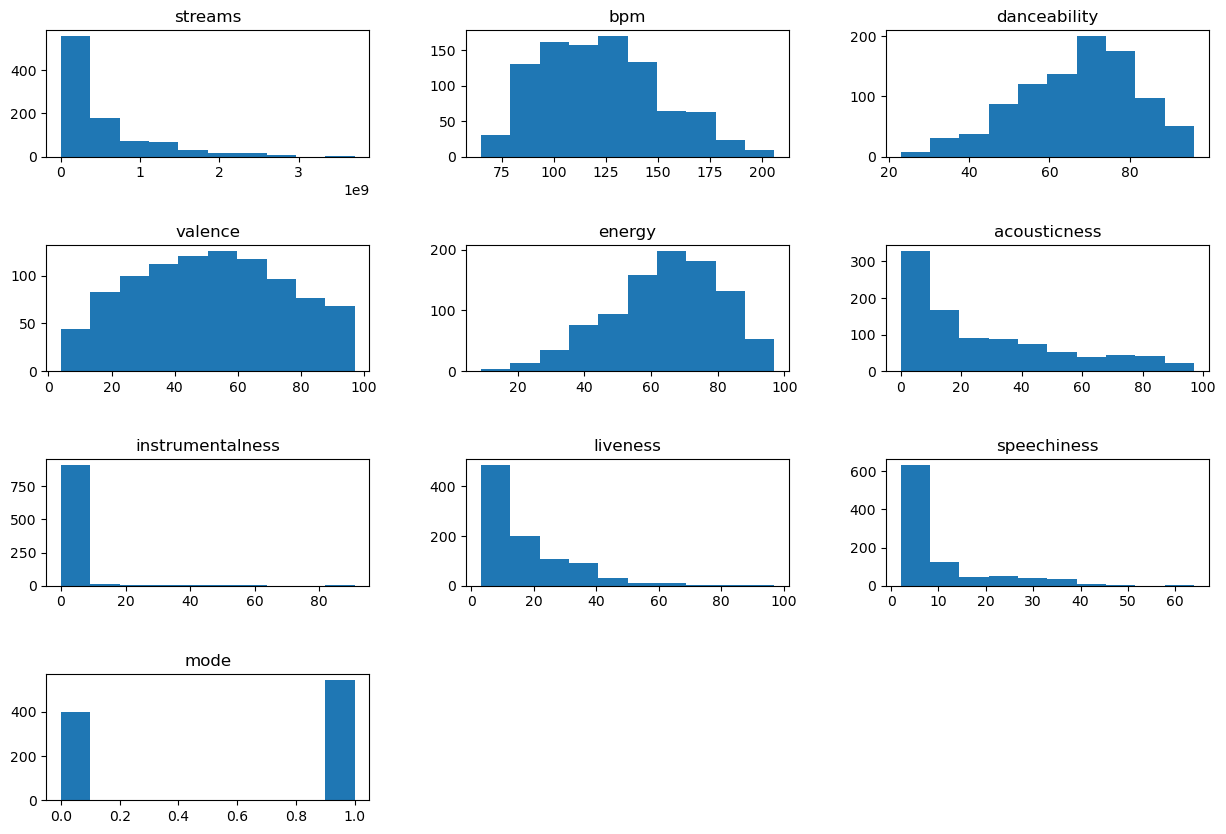

In [13]:
df.hist(figsize=(15, 10), grid=False);
plt.subplots_adjust(hspace=0.7);

We can see several distributions that are highly right skewed. This may call for some logarithmic transformation, but before we transform the training data, let's establish a baseline by checking how well the median stream count serves as a predictor. We'll use the median instead of the mean, due to the skewness of the streams distribution.

In [14]:
dumb_reg = DummyRegressor(strategy='median')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[19.4653641]])

In [15]:
y_train_pred = dumb_reg.predict(X_train)
y_test_pred = dumb_reg.predict(X_test)
y_train_pred[:5]

array([19.4653641, 19.4653641, 19.4653641, 19.4653641, 19.4653641])

The $R^2$ score, or coefficient of determination, tells us the proportion of variance in our target variable that is explained by our predictive model. This is equal to 1 minus the ratio of residual sum of squares over the total sum of squares, denoted by:

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

The residiual sum of squares represents the variance of our predictions and the total sum of squares represents the variance of the acual data. If we were to use a mean-based baseline predictor, our $R^2$ score would be 0. A model that perfectly precicts the target variables would have an $R^2$ of 1.

In [16]:
r2_score(np.exp(y_train), np.exp(y_train_pred)), r2_score(np.exp(y_test), np.exp(y_test_pred))

(-0.1784750060545166, -0.13852008359433277)

Our median-based model sets a low threshold for improvement, but again the skewness of the data isn't doing us any favors, and may be something to transform further along in the preprocessing. As we set evaluation benchmarks for our models, we'll also look at mean absolue error (MAE) which depicts the absolute value average difference between actual values and predictions: 

$$MAE = \frac{1}{n}\sum_i^n|y_i - \hat{y}|$$

While $R^2$ tells us the proportion of overall variance predicted by our model, the MAE tells us on average, how close our predictions are to the actual outcomes.

In [17]:
mean_absolute_error(np.exp(y_train), np.exp(y_train_pred)), mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))

(379362732.0060514, 344090522.00352114)

Perhaps it would be stating the obvious to say that a median-based predictor with the data at their current state, leaves room for a pretty large margin of error. Our test set predictions could be expected bo off by 344M streams. We'll need to do better than this.

## Reviewing Feature and Target Correlations

In [18]:
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'streams', data=df, alpha=0.5)
        ax.set(xlabel=col, ylabel='streams')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

#Function derived from Capstone 1 exploratory analysis

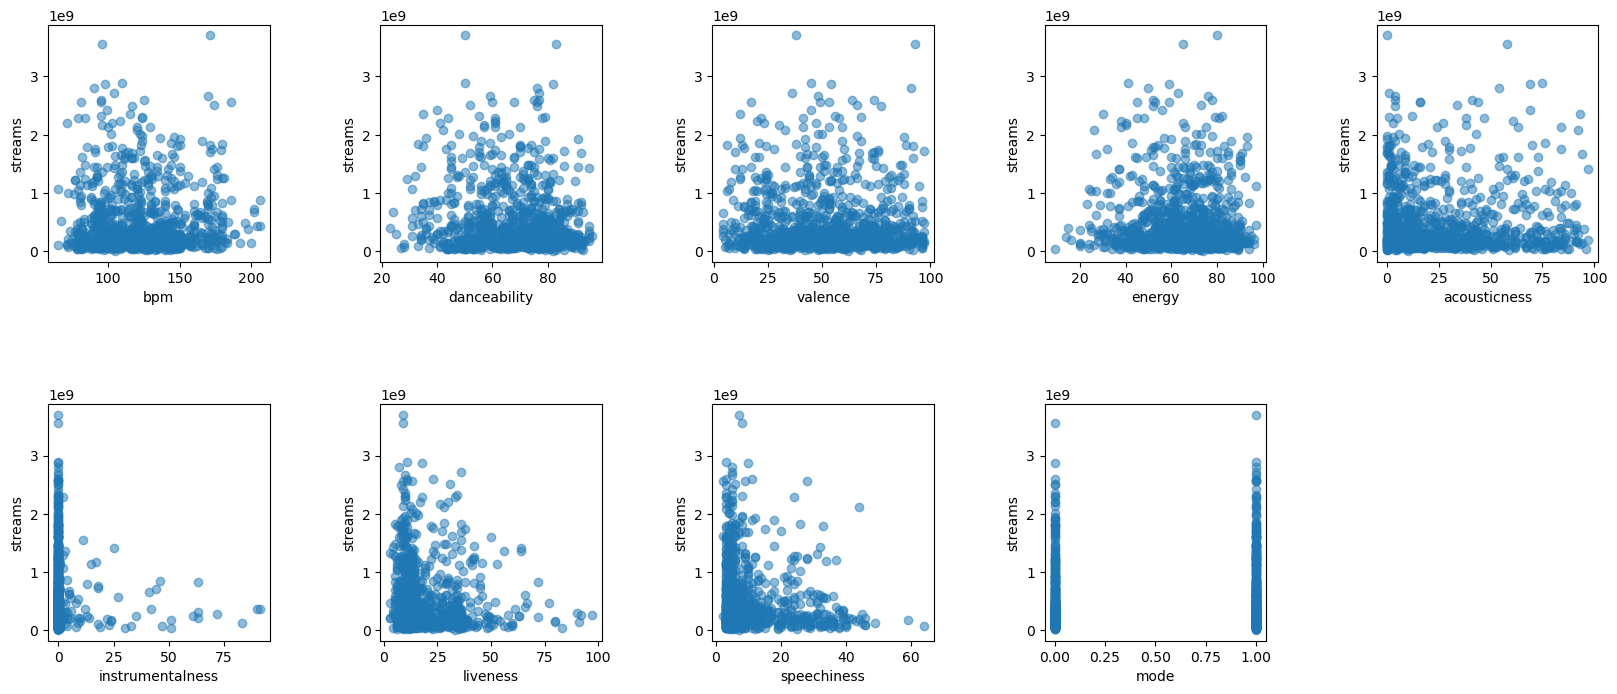

In [19]:
scatterplots(list(df.drop(columns='streams').columns), ncol=5, figsize=(20, 8))

Given that the data don't represent a linear correlation, let's try out a few decision tree models.

## Random Forest

We will surely be tuning our hyperparameters, but to start, let's see how our model performs out of the box. We'll also declare a function to expedite our performance measurement process, yielding the $R^2$ score and the MAE for both the train and test predictions.

In [20]:
def measure(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print('Train, Test R2: ', round(r2_score(np.exp(y_train), np.exp(y_train_pred)), 4), 
                              round(r2_score(np.exp(y_test), np.exp(y_test_pred)), 4))
    print('Train, Test MAE: ', round(mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))), 
                                round(mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))))

In [22]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
measure(rf)

Train, Test R2:  0.6198 -0.0799
Train, Test MAE:  186014306 342087157


### Hyperparameter Tuning

The intial random forest regressor is only a slight improvement on the median-predicting baseline. Let's try tuning some hyperparameter values. We'll start by exploring changes in one hyperparameter at a time, and then use these estimates to set a range of values to explore over multiple hyperparameter tunings at once.

In [23]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### n_estimators

In [24]:
scores = []
trees = [int(x) for x in np.linspace(100, 2000, 20)]
for i in trees:
    rf = RandomForestRegressor(n_estimators=i, random_state=42)
    pred = rf.fit(X_train, y_train).predict(X_test)
    mae = round(mean_absolute_error(np.exp(y_test), np.exp(pred)))
    scores.append(mae)
pd.DataFrame({'trees': trees, 'mae': scores})

,trees,mae
0,100,342087157
1,200,339439136
2,300,341647521
3,400,341034026
4,500,340868233
5,600,340518636
6,700,340257262
7,800,340069179
8,900,340187065
9,1000,339795958


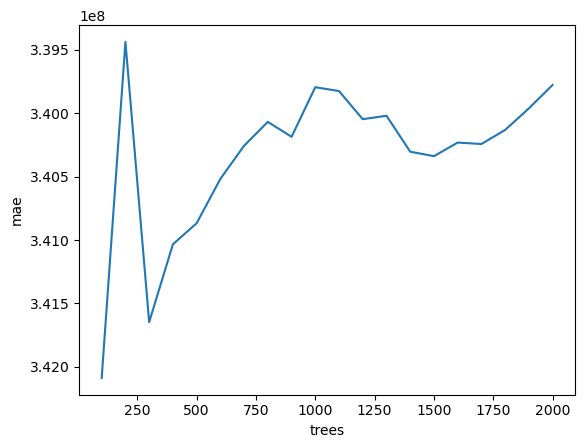

In [26]:
plt.plot(trees, scores);
ax = plt.gca()
ax.invert_yaxis();
ax.set_xlabel('trees');
ax.set_ylabel('mae');

### max_features

In [27]:
scores = []
features = [x for x in range(4, X_train.shape[1]+1)]
for i in features:
    rf = RandomForestRegressor(n_estimators=200, max_features=i, random_state=42)
    pred = rf.fit(X_train, y_train).predict(X_test)
    mae = round(mean_absolute_error(np.exp(y_test), np.exp(pred)))
    scores.append(mae)
pd.DataFrame({'features': features, 'mae': scores})

,features,mae
0,4,339063804
1,5,337774275
2,6,336365175
3,7,342420713
4,8,339674208
5,9,339439136


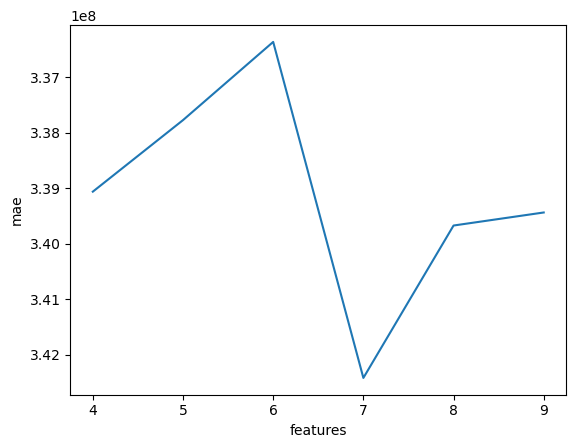

In [28]:
plt.plot(features, scores);
ax = plt.gca()
ax.invert_yaxis();
ax.set_xlabel('features');
ax.set_ylabel('mae');

### max_depth

In [29]:
scores = []
depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
for i in depth:
    rf = RandomForestRegressor(n_estimators=200, max_features=6, max_depth=i, random_state=42)
    pred = rf.fit(X_train, y_train).predict(X_test)
    mae = round(mean_absolute_error(np.exp(y_test), np.exp(pred)))
    scores.append(mae)
pd.DataFrame({'depth': depth, 'mae': scores})

,depth,mae
0,10.0,336899318
1,20.0,336750425
2,30.0,336365175
3,40.0,336365175
4,50.0,336365175
5,60.0,336365175
6,70.0,336365175
7,80.0,336365175
8,90.0,336365175
9,100.0,336365175


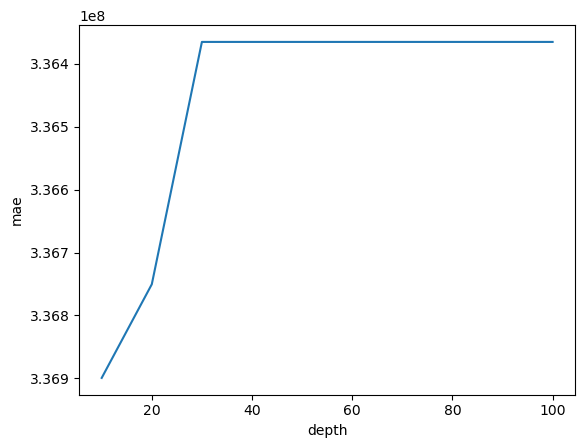

In [30]:
plt.plot(depth, scores);
ax = plt.gca()
ax.invert_yaxis();
ax.set_xlabel('depth');
ax.set_ylabel('mae');

### min_samples_split

In [31]:
scores = []
samples = [x for x in range(2,11)]
for i in samples:
    rf = RandomForestRegressor(n_estimators=200, max_features=6, max_depth=30, min_samples_split=i, random_state=42)
    pred = rf.fit(X_train, y_train).predict(X_test)
    mae = round(mean_absolute_error(np.exp(y_test), np.exp(pred)))
    scores.append(mae)
pd.DataFrame({'min_samples_split': samples, 'mae': scores})

,min_samples_split,mae
0,2,336365175
1,3,339638128
2,4,336489114
3,5,339189709
4,6,337856397
5,7,335264608
6,8,336000221
7,9,337080147
8,10,336589205


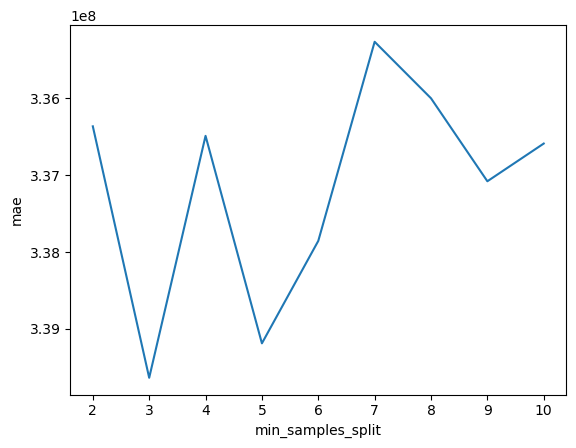

In [32]:
plt.plot(samples, scores);
ax = plt.gca()
ax.invert_yaxis();
ax.set_xlabel('min_samples_split');
ax.set_ylabel('mae');

### min_samples_leaf

In [33]:
scores = []
samples = [x for x in range(2,16)]
for i in samples:
    rf = RandomForestRegressor(n_estimators=200, max_features=6, max_depth=30, min_samples_split=7, min_samples_leaf=i, random_state=42)
    pred = rf.fit(X_train, y_train).predict(X_test)
    mae = round(mean_absolute_error(np.exp(y_test), np.exp(pred)))
    scores.append(mae)
pd.DataFrame({'min_samples_leaf': samples, 'mae': scores})

,min_samples_leaf,mae
0,2,335630880
1,3,336283449
2,4,335360302
3,5,334279183
4,6,333908256
5,7,333423400
6,8,332802809
7,9,332977193
8,10,333232388
9,11,332382359


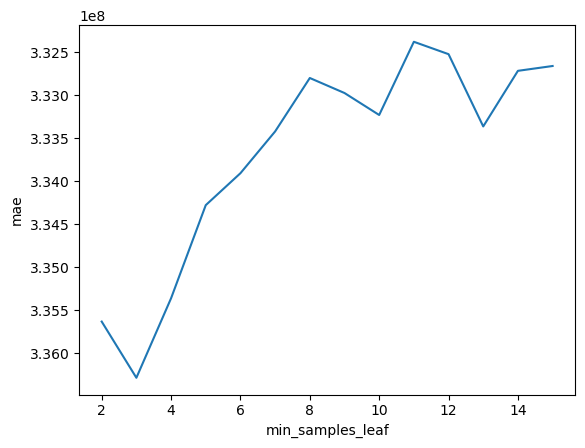

In [34]:
plt.plot(samples, scores);
ax = plt.gca()
ax.invert_yaxis();
ax.set_xlabel('min_samples_leaf');
ax.set_ylabel('mae');

We've optimized our model by tuning one hyperparameter at a time. But what if hyperparameters' ability to improve the model are dependent on one another. Now, we'll try tuning multiple hyperparameters at once and see if we get any further improvement. 

### Randomized Search CV

The Randomized Search CV allows us to cross validate our model's performance across different combinations of hyperparameter values, giving us a ballpark estimate of where the best values might be. Let's use ranges surrounding our best hyperparameters as determined so far, and see if a different combination yields an even better result. As a reminder, here is our best model so far.

In [35]:
rf = RandomForestRegressor(n_estimators=200, max_features=6, max_depth=30, min_samples_split=7, min_samples_leaf=11, random_state=42)
rf.fit(X_train, y_train)
measure(rf)

Train, Test R2:  0.0307 -0.0566
Train, Test MAE:  335509930 332382359


In [39]:
params = {'n_estimators': [x for x in range(160, 260, 10)],
               'max_depth': [x for x in range(22, 42, 2)],
               'max_features': [4, 5, 6],
               'min_samples_split': [2, 4, 7],
               'min_samples_leaf': [8, 11, 15]}

rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), param_distributions=params, n_iter=100, 
                               cv=5, random_state=42, n_jobs = -1, scoring=make_scorer(mean_absolute_error))

#Adapeted from:
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [40]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [22, 24, 26, 28, 30, 32,
                                                      34, 36, 38, 40],
                                        'max_features': [4, 5, 6],
                                        'min_samples_leaf': [8, 11, 15],
                                        'min_samples_split': [2, 4, 7],
                                        'n_estimators': [160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250]},
                   random_state=42, scoring=make_scorer(mean_absolute_error))

In [42]:
measure(rf_random.best_estimator_)

Train, Test R2:  0.087 -0.0591
Train, Test MAE:  320961312 332982082


Not quite as good as our custom-tuned model, so we'll stick with the custom. While we've managed to improve performance through hyperparameter tuning, we still have a model with a prediction error of over 300M streams, which is our target number of streams to generate! Additionally, we would like a much higher value for the $R^2$ score. We certainly have more work to do. Let's compare the performance of a couple of other models to check if there's a better option than the random forest at this stage.

## Extra Trees

In [43]:
et = ExtraTreesRegressor(random_state=42)
et.fit(X_train, y_train)
measure(et)

Train, Test R2:  1.0 -0.0615
Train, Test MAE:  0 339581775


In [44]:
et_random = RandomizedSearchCV(estimator=et, param_distributions=params, n_iter=100, 
                               cv=5, random_state=42, n_jobs = -1, scoring=make_scorer(mean_absolute_error))

In [45]:
et_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [22, 24, 26, 28, 30, 32,
                                                      34, 36, 38, 40],
                                        'max_features': [4, 5, 6],
                                        'min_samples_leaf': [8, 11, 15],
                                        'min_samples_split': [2, 4, 7],
                                        'n_estimators': [160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250]},
                   random_state=42, scoring=make_scorer(mean_absolute_error))

In [46]:
measure(et_random.best_estimator_)

Train, Test R2:  0.0023 -0.0683
Train, Test MAE:  341900888 335486415


The random search over hyperparameter ranges as determined from a best random forest performance, improved the MAE of the extra trees regressor and reduced its overfitting, but our random forest model still prevails.

## Gradient Boosting

In [47]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
measure(gb)

Train, Test R2:  0.1417 -0.1033
Train, Test MAE:  310431184 348365598


In [48]:
gb_random = RandomizedSearchCV(estimator=gb, param_distributions=params, n_iter=100, 
                               cv=5, random_state=42, n_jobs = -1, scoring=make_scorer(mean_absolute_error))

In [49]:
gb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [22, 24, 26, 28, 30, 32,
                                                      34, 36, 38, 40],
                                        'max_features': [4, 5, 6],
                                        'min_samples_leaf': [8, 11, 15],
                                        'min_samples_split': [2, 4, 7],
                                        'n_estimators': [160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250]},
                   random_state=42, scoring=make_scorer(mean_absolute_error))

In [50]:
measure(gb_random.best_estimator_)

Train, Test R2:  0.9937 -0.1794
Train, Test MAE:  18049662 375475013


Our random forest model still performs best. We'll proceed to feature scaling with this model.

## Scaling Data

As saw from the histograms, a few of our features are highly right skewed. We will explore a few different options for scaling our data to see which is most effective: Standard Scaler, Min Max Scaler, Robust Scaler, and Power Transformer. We'll compare each of these to see how they effect the performance of our tuned random forest model.

In [52]:
def scale(scaler):
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    rf.fit(X_train_scaled, y_train)
    y_train_pred = rf.predict(X_train_scaled)
    y_test_pred = rf.predict(X_test_scaled)
    print('Train, Test R2: ', round(r2_score(np.exp(y_train), np.exp(y_train_pred)), 4), 
                              round(r2_score(np.exp(y_test), np.exp(y_test_pred)), 4))
    print('Train, Test MAE: ', round(mean_absolute_error(np.exp(y_train), np.exp(y_train_pred))), 
                                round(mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))))

In [53]:
scale(StandardScaler())

Train, Test R2:  0.0307 -0.0561
Train, Test MAE:  335519279 332398709


In [55]:
scale(MinMaxScaler())

Train, Test R2:  0.0307 -0.0564
Train, Test MAE:  335513788 332314500


In [56]:
scale(RobustScaler())

Train, Test R2:  0.0309 -0.0564
Train, Test MAE:  335501896 332298151


In [57]:
scale(PowerTransformer())

Train, Test R2:  0.0309 -0.0551
Train, Test MAE:  335486030 332187601


The power transformer scaling improved performance the most, which was expected given that it uses a logarthmic transformation and several of our distributions were skewed. Nonetheless, considering our model's weak performance with both hyperparameter tuning and feature scaling, let's revisit our input data and consider some other options. First we'll evaluate performance on different subsets of the data. If this doesn't improve our ability to predict streams from musical features, we'll consider redefining our features and target variable, for a more roundabout approach to achieving our desired outcome. Let's make a pipeline of our best working model with the power transformer scaling to use on our experimental feature / target sets. 

In [58]:
pipe = Pipeline([('transformation', PowerTransformer()),
                       ('model', rf)])

In [63]:
pipe

Pipeline(steps=[('transformation', PowerTransformer()),
                ('model',
                 RandomForestRegressor(max_depth=30, max_features=6,
                                       min_samples_leaf=11, min_samples_split=7,
                                       n_estimators=200, random_state=42))])

## Refining the Dataset

After seeing that transformations didn't do much to help a linear model's predictability on our data, let's check if an 80/20 split makes a difference.

In [74]:
#80/20
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='streams'), np.log(df['streams']), test_size=0.2, random_state=42)
pipe.fit(X_train, y_train)
measure(pipe)

Train, Test R2:  0.04 -0.0479
Train, Test MAE:  335348554 313615568


Wow, so access to more training data did boost model performance. What if we did an even bigger split?

In [75]:
#90/10
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='streams'), np.log(df['streams']), test_size=0.1, random_state=42)
pipe.fit(X_train, y_train)
measure(pipe)

Train, Test R2:  0.0509 -0.044
Train, Test MAE:  331931150 267616026


We may be on to something here. We don't want to split our train and test sets further as we have limited total observations. Future work could significantly benefit from accruing more data. For now, given the 945 observations that we have to work with, let's return to the original dataframe and deal with the outliers that might be obstructing the model's ability to make accurate predictions.

### Removing Target Variable Outliers

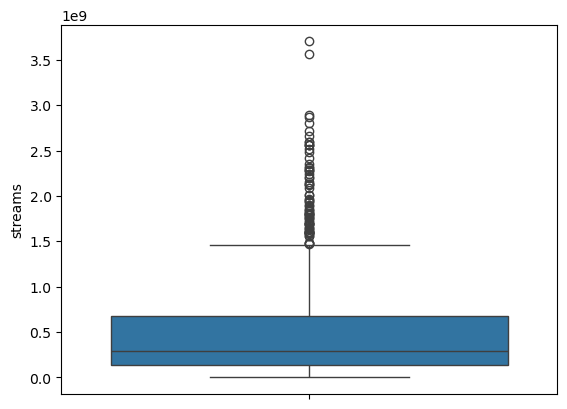

In [66]:
sns.boxplot(data=df['streams']);

The boxplot highlights that some strongs have significantly more streams than most songs in the dataset. Could this be interfering with our predictions? Let's see how things look if we trim our dataset to remove stream count outliers that are above the 95% threshold.

In [67]:
#Keep original index for cross reference with song and artist names
df_reduced_og_index = df[df['streams'] < df['streams'].quantile(0.95)]
df_reduced = df_reduced_og_index.reset_index(drop=True)

In [68]:
df_reduced.shape

(897, 10)

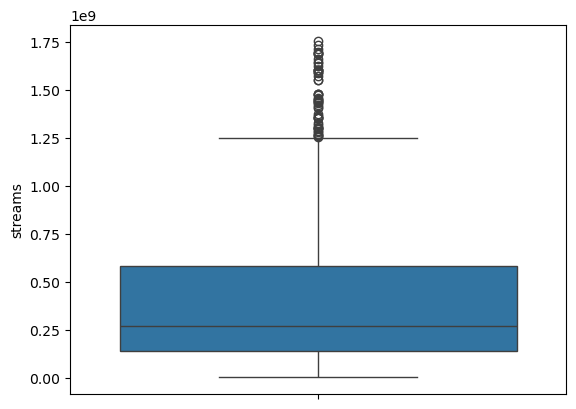

In [69]:
sns.boxplot(data=df_reduced['streams']);

While we still have some outliers, we can check if removing the top 5% of streams improves the random forest's predictive ability. We'll need to re-define our train/test split according to the new dataframe. Let's also check performance for multiple split ratios.

In [73]:
#70/30
X_train, X_test, y_train, y_test = train_test_split(df_reduced.drop(columns='streams'), np.log(df_reduced['streams']), test_size=0.3, random_state=42)
pipe.fit(X_train, y_train)
measure(pipe)

Train, Test R2:  0.0773 -0.0845
Train, Test MAE:  246331290 278404820


In [76]:
#80/20
X_train, X_test, y_train, y_test = train_test_split(df_reduced.drop(columns='streams'), np.log(df_reduced['streams']), test_size=0.2, random_state=42)
pipe.fit(X_train, y_train)
measure(pipe)

Train, Test R2:  0.0763 -0.0901
Train, Test MAE:  247020242 270222406


In [78]:
#90/10
X_train, X_test, y_train, y_test = train_test_split(df_reduced.drop(columns='streams'), np.log(df_reduced['streams']), test_size=0.1, random_state=42)
pipe.fit(X_train, y_train)
measure(pipe)

Train, Test R2:  0.0845 -0.192
Train, Test MAE:  242603261 297204987


We see better MAE's but worse $R^2$'s compared to our predictions based on all observations. Instead of reducing observations, what happens when we add additional features?

## Considering Additional Features

In [87]:
df_all = pd.read_csv('spotify_2023_cleaned.csv', index_col=0)
df_all.head()

,track_name,artist(s)_name,artist_count,year,month,day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,release_date
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,0,0,0,0,0,0,0,0,0,2023-07-14
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,0,0,0,0,0,0,1,0,0,2023-03-23
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,0,0,0,0,0,1,0,0,0,2023-06-30
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,0,0,0,0,0,0,0,0,0,2019-08-23
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,0,0,0,0,0,0,0,0,0,2023-05-18


In [88]:
df_all.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'year', 'month', 'day',
       'in_spotify_playlists', 'in_spotify_charts', 'streams',
       'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists',
       'in_deezer_charts', 'in_shazam_charts', 'bpm', 'mode', 'danceability_%',
       'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%',
       'liveness_%', 'speechiness_%', 'key_A', 'key_A#', 'key_B', 'key_C',
       'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G',
       'key_G#', 'release_date'],
      dtype='object')

We can drop some of these columns. Let's refine our dataframe to include all music features (except the keys as these had some missing values), all playlist and chart information (except Shazam charts since this had some missing values), as well as release day and month. Release year isn't relevant to our analysis since we are releasing our songs next year, but perhaps the day and month that the song is released affecs the stream count. As we saw in our exploratory data analysis, many of the songs were released in January or December.

In [89]:
df_all.drop(columns=['track_name', 'artist(s)_name', 'artist_count', 'year', 'in_shazam_charts', 'key_A', 'key_A#', 'key_B', 
                           'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'release_date'], inplace=True)

In [90]:
dummies = pd.get_dummies(df_all[['month', 'day', 'mode']].astype('category'), prefix=['month', 'day', 'mode'], dtype='int')
df_all = pd.concat([df_all.drop(columns=['month', 'day', 'mode']), dummies], axis=1)
df_all.head()

,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,bpm,danceability_%,valence_%,...,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,mode_0,mode_1
0,553,147,141381703,43,263,45,10,125,80,89,...,0,0,0,0,0,0,0,0,0,1
1,1474,48,133716286,48,126,58,14,92,71,61,...,0,0,0,0,0,0,0,0,0,1
2,1397,113,140003974,94,207,91,14,138,51,32,...,0,0,0,0,0,0,1,0,0,1
3,7858,100,800840817,116,207,125,12,170,55,58,...,0,0,0,0,0,0,0,0,0,1
4,3133,50,303236322,84,133,87,15,144,65,23,...,0,0,0,0,0,0,0,0,1,0


In [91]:
all_feature_names = list(df_all.drop(columns='streams').columns)

Let's see how an untuned model performs with these additional features.

In [92]:
rf_untuned = RandomForestRegressor(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df_all.drop(columns='streams'), np.log(df_all['streams']), test_size=0.2, random_state=42)
rf_untuned.fit(X_test, y_test)
measure(rf_untuned)

Train, Test R2:  0.7503 0.931
Train, Test MAE:  178707817 67323976


Wow! These additional features significantly improved model performance. This is likely do to the inclusion of playlist and chart columns which  correlate with streams. Let's examine the respective feature importances.

In [94]:
df_all_feat_imp = pd.DataFrame({'feature': all_feature_names, 'importance': rf_untuned.feature_importances_}).sort_values('importance', ascending=False)
df_all_feat_imp.head(20)

,feature,importance
0,in_spotify_playlists,0.730111
4,in_deezer_playlists,0.052923
7,danceability_%,0.025682
2,in_apple_playlists,0.024174
8,valence_%,0.023926
1,in_spotify_charts,0.019272
3,in_apple_charts,0.016740
6,bpm,0.015027
10,acousticness_%,0.014126
12,liveness_%,0.012162


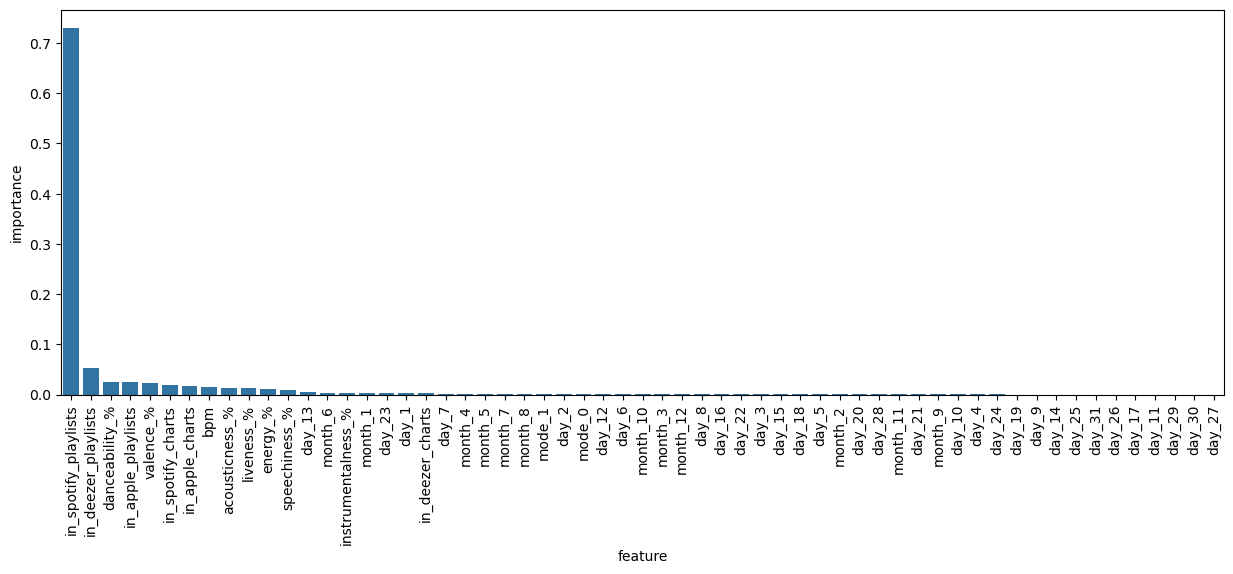

In [95]:
plt.subplots(figsize=(15,5));
sns.barplot(df_all_feat_imp, x='feature', y='importance');
plt.xticks(rotation=90);

The number of Spotify playlists is a huge indicator of number of total streams on Spotify. Our obvious takeaway is that no matter what songs we pick, getting them playlisted will be the most important factor to achieving more streams. But our goal is to use the musical properties to pick which songs to promote and get playlisted in the first place. Since we haven't had success in predicting stream count based on music features, what would happen if we instead attempt to predict the number of playlists that a songs appears in?

## Playlist as Target Variable

Since we see that the date columns don't have much significance, let's refine our dataframe back to just the musical features, but exclude streams and instead use the Spotify playlists as our target variable.

In [96]:
df_all.columns

Index(['in_spotify_playlists', 'in_spotify_charts', 'streams',
       'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists',
       'in_deezer_charts', 'bpm', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8',
       'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15',
       'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22',
       'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29',
       'day_30', 'day_31', 'mode_0', 'mode_1'],
      dtype='object')

In [97]:
df_all = df_all[['in_spotify_playlists', 'bpm', 'danceability_%', 'valence_%', 'energy_%', 
                   'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'mode_0', 'mode_1']]
df_all.rename({'in_spotify_playlists': 'playlists', 'danceability_%': 'danceability', 'valence_%': 'valence', 
                'energy_%': 'energy', 'acousticness_%': 'acousticness', 'instrumentalness_%': 'instrumentalness', 
                'liveness_%': 'liveness', 'speechiness_%': 'speechiness'}, axis=1, inplace=True)
df_all.head()

,playlists,bpm,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,mode_0,mode_1
0,553,125,80,89,83,31,0,8,4,0,1
1,1474,92,71,61,74,7,0,10,4,0,1
2,1397,138,51,32,53,17,0,31,6,0,1
3,7858,170,55,58,72,11,0,11,15,0,1
4,3133,144,65,23,80,14,63,11,6,1,0


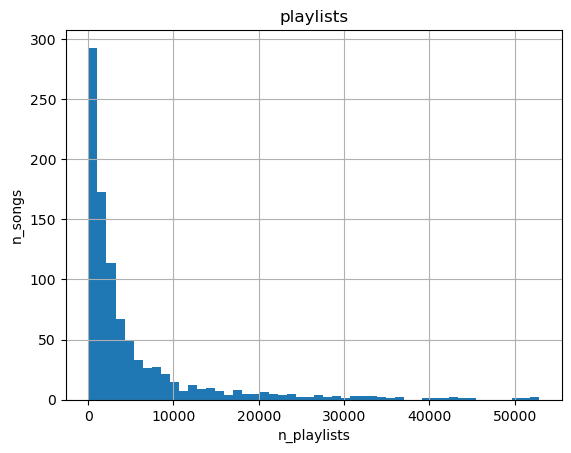

In [98]:
df_all[['playlists']].hist(bins=50);
plt.gca().set_xlabel('n_playlists');
plt.gca().set_ylabel('n_songs');

In [108]:
X_train, X_test, y_train, y_test = train_test_split(df_all.drop(columns='playlists'), df_all['playlists'], test_size=0.2, random_state=42)
rf_untuned.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

We'll need to redefine a measure function that doesn't account for the log transformatin of the target variable, as here we're using the raw numbers for the target.

In [109]:
def measure2(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print('Train, Test R2: ', round(r2_score(y_train, y_train_pred), 4), 
                              round(r2_score(y_test, y_test_pred), 4))
    print('Train, Test MAE: ', round(mean_absolute_error(y_train, y_train_pred)), 
                                round(mean_absolute_error(y_test, y_test_pred)))

In [110]:
measure2(rf_untuned)

Train, Test R2:  0.8381 -0.1471
Train, Test MAE:  2159 5148


The playlist prediction ability isn't looking better than our stream prediction ability. The MAE is now in units of playlists rather than units of streams, so an error of ~5K is relative to much fewer playlists per song than streams per song. Let's compare the pipeline to see if this noticeably improves this model that uses playlists as the target.

In [111]:
pipe.fit(X_train, y_train)
measure2(pipe)

Train, Test R2:  0.2497 0.0032
Train, Test MAE:  4498 4549


Our first positive $R^2$! Even though this feels like an achievement compared to our prior 'stream' ;) of negative scores, these values still aren't up to par. For a final target variable consideration, let's consider grouping stream counts into deciles. This should help to consolidate outliers and we won't have to transform the outlier as will be a score from 1-10. We'll also compare the difference of dividing streams into 20 even bins.

## Streams Target in Deciles

In [176]:
df_ds = df.copy()
df_ds['d'] = pd.qcut(df_ds['streams'], 10, labels=np.arange(10) + 1)
df_ds['d2'] = pd.qcut(df_ds['streams'], 20, labels=np.arange(20) + 1)
df_ds.head()

,streams,bpm,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,mode,d,d2
0,141381703,125,80,89,83,31,0,8,4,1,3,5
1,133716286,92,71,61,74,7,0,10,4,1,3,5
2,140003974,138,51,32,53,17,0,31,6,1,3,5
3,800840817,170,55,58,72,11,0,11,15,1,8,16
4,303236322,144,65,23,80,14,63,11,6,0,6,11


In [165]:
for i in range(1, 11):
    print(f'd_{i}', df_qs['streams'][df_ds['d'] == i].min(), df_ds['streams'][df_ds['d'] == i].max())

d_1 1365184 71423324
d_2 71573339 121077868
d_3 121189256 167076418
d_4 168448603 221752937
d_5 222410722 290833204
d_6 291709698 383835984
d_7 387080183 554875730
d_8 556585270 822239726
d_9 822633917 1302184087
d_10 1304313953 3703895074


In [166]:
for i in range(1, 21):
    print(f'd_{i}', df_qs['streams'][df_ds['d2'] == i].min(), df_ds['streams'][df_ds['d2'] == i].max())

d_1 1365184 53729194
d_2 53909146 71423324
d_3 71573339 95131998
d_4 95217315 121077868
d_5 121189256 142095275
d_6 143139338 167076418
d_7 168448603 189236868
d_8 189476119 221752937
d_9 222410722 248088961
d_10 248511839 290833204
d_11 291709698 333146475
d_12 334733572 383835984
d_13 387080183 460492795
d_14 461437791 554875730
d_15 556585270 673801126
d_16 674072710 822239726
d_17 822633917 1062345656
d_18 1062956628 1302184087
d_19 1304313953 1755214421
d_20 1759567999 3703895074


To match the target of 300M streams, we'd want for our song to be categorized no lower than d_6 or d_11, respective of the 10 or 20 bin divisions. As the miniumum of each of our bins falls below ourr threshold, we'd prefer if our songs could score higher than these bins. Let's evaluate model performance for each of the splits.

In [168]:
X_train, X_test, y_train, y_test = train_test_split(df_ds.drop(columns=['streams', 'd', 'd2']), df_ds['d'], test_size=0.2, random_state=42)
rf_untuned.fit(X_train, y_train)
measure2(rf_untuned)

Train, Test R2:  0.8502 0.0447
Train, Test MAE:  1 2


In [169]:
pipe.fit(X_train, y_train)
measure2(pipe)

Train, Test R2:  0.2919 0.0601
Train, Test MAE:  2 2


In [170]:
X_train, X_test, y_train, y_test = train_test_split(df_ds.drop(columns=['streams', 'd', 'd2']), df_ds['d2'], test_size=0.2, random_state=42)
rf_untuned.fit(X_train, y_train)
measure2(rf_untuned)

Train, Test R2:  0.8499 0.0555
Train, Test MAE:  2 5


In [171]:
pipe.fit(X_train, y_train)
measure2(pipe)

Train, Test R2:  0.288 0.0527
Train, Test MAE:  4 5


The best performance we've achieved yet is the pipeline's fit to the 10-decile target, though our $R^2$ is still less than 0.1. With an MAE of 2, we would need for our songs to be predicted to be at least as high as d_8 or d_9 to expect a stream count over 300M. Let's see how our predictions fare if we use playlists as our target variable, divided into deciles.

## Playlist Target in Deciles

In [177]:
df_dp = df.copy()
df_dp = pd.concat([df.drop(columns='streams'), df_all[['playlists']]], axis=1)
df_dp['d'] = pd.qcut(df_dp['playlists'], 10, labels=np.arange(10) + 1)
df_dp['d2'] = pd.qcut(df_dp['playlists'], 20, labels=np.arange(20) + 1)
df_dp.head()

,bpm,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness,mode,playlists,d,d2
0,125,80,89,83,31,0,8,4,1,553,2,3
1,92,71,61,74,7,0,10,4,1,1474,4,8
2,138,51,32,53,17,0,31,6,1,1397,4,8
3,170,55,58,72,11,0,11,15,1,7858,9,17
4,144,65,23,80,14,63,11,6,0,3133,7,13


In [178]:
X_train, X_test, y_train, y_test = train_test_split(df_dp.drop(columns=['playlists', 'd', 'd2']), df_dp['d'], test_size=0.2, random_state=42)
rf_untuned.fit(X_train, y_train)
measure2(rf_untuned)

Train, Test R2:  0.8462 0.0282
Train, Test MAE:  1 2


In [179]:
pipe.fit(X_train, y_train)
measure2(pipe)

Train, Test R2:  0.2842 0.0395
Train, Test MAE:  2 2


In [180]:
X_train, X_test, y_train, y_test = train_test_split(df_dp.drop(columns=['playlists', 'd', 'd2']), df_dp['d2'], test_size=0.2, random_state=42)
rf_untuned.fit(X_train, y_train)
measure2(rf_untuned)

Train, Test R2:  0.8479 0.0228
Train, Test MAE:  2 5


In [181]:
pipe.fit(X_train, y_train)
measure2(pipe)

Train, Test R2:  0.2839 0.042
Train, Test MAE:  4 5


Our best estimates so far still come from using the streams-deciles as the target, rather than the playlist target.

## Summary

We've examined a variety of considerations in how to best yield accurate predictions from streams counts. We assessed hyperparameter tunings across random forest, extra trees, and gradient boosting regressors. We determined a tuned random forest regressor to yield the best performance so far, though additional examination will be necessary as we still haven't achieved an optimal coefficient of determination or mean absolute error. We found that using Sklearn's Power Transformer transformation on our feature data improved our results. We also explored different train/test split sizes to achieve better test set predictions. We considered removing outlier observations with a disproportionately high stream count, as well as adding features for predictive reinforcement. While our model performed much better with additional features pertaining to playist and chart counts, using this information in our analysis subverts our real world scenario, as we are selecting songs from Regression Records' catalog that have not yet been playlisted or charted. Thus, we even considered using Spotify playlist count as the target variable instead of stream count, but found that this didn't lead to enough improvement in the model to justify the variable pivot. Finally, to simplify the complexity of the multimillion stream count predictions, we organized the observations into evenly spaced deciles based on total streams. This enabled our predictions to predict a range of streams, rather than a specific number, and significantly improved model performance, finally yielding a positive $R^2$ score and a MAE of 2 deciles. With this current error range, songs ranked in deciles 8-10 are our best bets for achieving 300M streams, specifically in regards to music features. We have a lot more to consider, given that our model is still underperforming compared to the desired outcome. As we delve deeper into modeling, we will further scrutinize train/test split sizes and different model options, perform thorough cross validation, and a take deeper dive into hyperparameter tuning.